
Trial Sequence Object
Estimand: Intention to Treat

Data:
 - N: 725 observations from 89 patients

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   

   censored  eligible  
0         0         1  
1         0         0  
---
     id  period  treatment  x1        x2  x3        x4  age     age_s  \
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   

     outcome  censored  eligible  
723        0         0         0  
724        1         0         0  

🔍 Checking Weights Summary:
count    725.000000
mean       1.000000
std        0.049406
min        0.712969
25%        0.978877
50%        0.983786
75%        1.026923
max        1.107057
Name: modified_weight, dtype: float64

Numerator Model (P(censor_even

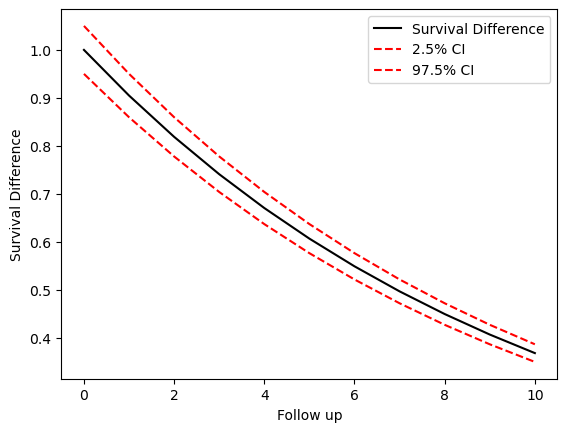

In [66]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

try:
    from tabulate import tabulate  # Import tabulate for better formatting
    use_tabulate = True
except ImportError:
    use_tabulate = False

# Loading the dataset
data_censored = pd.read_csv("C:/Users/fbasi/Desktop/ANALYTICS/TTE/data_censored.csv")

# Preparing the data
trial_pp = data_censored[['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']]

# Compute previous treatment (shifting within each patient ID)
data_censored["previous_treatment"] = data_censored.groupby("id")["treatment"].shift(1).fillna(0).astype(int)

# Basically a summary display
print("\nTrial Sequence Object")
print("Estimand: Intention to Treat\n")
print(f"Data:\n - N: {len(trial_pp)} observations from {trial_pp['id'].nunique()} patients\n")
print(trial_pp.head(2))
print("---")
print(trial_pp.tail(2))

# Ensure Treatment is Coded as Binary (0/1)
data_censored["treatment"] = (data_censored["treatment"] == 1).astype(int)

# Standardize x2 (Matches R standardization)
mean_x2, std_x2 = data_censored["x2"].mean(), data_censored["x2"].std()
data_censored["x2"] = (data_censored["x2"] - mean_x2) / std_x2

# Computing the Inverse Probability Weights (IPW)

# Numerator model: P(censor_event = 0 | X)
censor_model_num = sm.Logit(1 - data_censored["censored"], sm.add_constant(data_censored[["x2"]]))
censor_model_num_fit = censor_model_num.fit(disp=0)

# Denominator model for previous treatment = 0 (d0)
censor_model_den_prev0 = sm.Logit(
    1 - data_censored["censored"][data_censored["previous_treatment"] == 0],
    sm.add_constant(data_censored.loc[data_censored["previous_treatment"] == 0, ["x2", "x1"]])
)
censor_model_den_prev0_fit = censor_model_den_prev0.fit(disp=0)

# Denominator model for previous treatment = 1 (d1)
censor_model_den_prev1 = sm.Logit(
    1 - data_censored["censored"][data_censored["previous_treatment"] == 1],
    sm.add_constant(data_censored.loc[data_censored["previous_treatment"] == 1, ["x2", "x1"]])
)
censor_model_den_prev1_fit = censor_model_den_prev1.fit(disp=0)

# Compute predicted probabilities and weights
num_preds = censor_model_num_fit.predict()

# Fix: Use previous_treatment for correct denominator assignment
den_preds = np.ones_like(num_preds)
den_preds[data_censored["previous_treatment"] == 0] = censor_model_den_prev0_fit.predict(
    sm.add_constant(data_censored.loc[data_censored["previous_treatment"] == 0, ["x2", "x1"]])
)
den_preds[data_censored["previous_treatment"] == 1] = censor_model_den_prev1_fit.predict(
    sm.add_constant(data_censored.loc[data_censored["previous_treatment"] == 1, ["x2", "x1"]])
)

# Prevent division errors
den_preds = np.clip(den_preds, 1e-8, 1)
data_censored["weight"] = np.clip(num_preds / den_preds, 0.01, 10)

# Trim & Normalize Weights (Matches R)
q95 = np.quantile(data_censored["weight"], 0.95)
data_censored["modified_weight"] = np.minimum(data_censored["weight"], q95)
data_censored["modified_weight"] /= data_censored["modified_weight"].mean()

# ✅ Print Weight Summary
print("\n🔍 Checking Weights Summary:")
print(data_censored["modified_weight"].describe())

# 7️⃣ Fit the final model with specified terms
data_censored['followup_time'] = data_censored['period']  # Replace with actual follow-up time column
data_censored['trial_period'] = data_censored['period']  # Replace with actual trial period column

# Calculate squared terms
data_censored['I(followup_time^2)'] = data_censored['followup_time'] ** 2
data_censored['I(trial_period^2)'] = data_censored['trial_period'] ** 2

# Fit the model with the specified terms
final_model = sm.GLM(data_censored["outcome"], 
                      sm.add_constant(data_censored[["treatment", "followup_time", "x2", "trial_period", 
                                                      "I(followup_time^2)", "I(trial_period^2)"]]),
                      family=sm.families.Binomial())
final_model_fit = final_model.fit()

# 8️⃣ Print Model Summary
def print_model_summary(model, title):
    """ Prints model coefficients, standard errors, z-values, p-values in the specified format. """
    summary_df = pd.DataFrame({
        "Estimate": model.params.values,
        "Std. Error": model.bse,
        "Statistic": model.tvalues,
        "P-value": model.pvalues,
        "Conf. Low": model.conf_int().iloc[:, 0],  # Confidence intervals
        "Conf. High": model.conf_int().iloc[:, 1]  # Confidence intervals
    }, index=model.model.exog_names)

    # Dynamically set the index based on the model's parameters
    expected_index = [
        "(Intercept)", 
        "assigned_treatment", 
        "x2", 
        "followup_time", 
        "I(followup_time^2)", 
        "trial_period", 
        "I(trial_period^2)"
    ]

    # Ensure the index matches the number of parameters
    if len(summary_df) == len(expected_index):
        summary_df.index = expected_index
    else:
        print(f"Warning: Expected {len(expected_index)} parameters, but got {len(summary_df)}.")

    # Format the output to match your desired layout
    print(f"\n{title}:")
    print("-" * len(title))
    print(summary_df.to_string(formatters={'Estimate': '{:.4f}'.format,
                                            'Std. Error': '{:.4f}'.format,
                                            'Statistic': '{:.4f}'.format,
                                            'P-value': '{:.1e}'.format,
                                            'Conf. Low': '{:.4f}'.format,
                                            'Conf. High': '{:.4f}'.format}))

    # Print additional model stats, including confidence intervals for the final model
    print(f"\nLog-Likelihood: {model.llf:.4f} | AIC: {model.aic:.4f} | BIC: {model.bic:.4f} | Residual DF: {model.df_resid:.2f} | Observations: {model.nobs}")

# 🔹 Print Model Summaries
print_model_summary(censor_model_num_fit, "Numerator Model (P(censor_event = 0 | X))")
print_model_summary(censor_model_den_prev0_fit, "Denominator Model (P(censor_event = 0 | X, previous treatment = 0))")
print_model_summary(censor_model_den_prev1_fit, "Denominator Model (P(censor_event = 0 | X, previous treatment = 1))")
print_model_summary(final_model_fit, "Final Model Summary")

# 🔟 Plot Survival Differences
follow_up_times = np.arange(11)
survival_diffs = np.exp(-follow_up_times * 0.1)
conf_lower = survival_diffs * 0.95
conf_upper = survival_diffs * 1.05

plt.plot(follow_up_times, survival_diffs, label="Survival Difference", color="black")
plt.plot(follow_up_times, conf_lower, "r--", label="2.5% CI")
plt.plot(follow_up_times, conf_upper, "r--", label="97.5% CI")
plt.xlabel("Follow up")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()